In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import fcluster
import itertools
import scipy.stats as st
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from tqdm import tqdm
import random
import pickle
# rimuovo alcuni warn che disturbano l'output dei risultati
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

RANDOM_SEED = 42

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


#### Calcolo andamento medio per spotName con annesso intervallo di confidenza
Livello di significatività = 95%

In [2]:
dataset = pd.read_pickle("../data/prepared/prepared_dataset.pkl")
dataset

,spotName,Date,Time,n_week,CurrentCurve
0,60061_0_00,2019-09-17,17:33:48,38,"[312, 2067, 3862, 5267, 6398, 7217, 7959, 8700..."
75852,60075_0_00,2019-09-17,17:33:48,38,"[322, 2099, 3940, 5296, 6362, 7169, 7589, 7750..."
75853,60141_0_00,2019-09-17,17:33:48,38,"[214, 1995, 3836, 5125, 6107, 6813, 7182, 7427..."
75854,60163_0_00,2019-09-17,17:33:48,38,"[323, 2137, 4047, 5472, 6475, 7090, 7544, 7803..."
75855,60161_0_00,2019-09-17,17:33:48,38,"[327, 2161, 4126, 5468, 6483, 7237, 7662, 7793..."
...,...,...,...,...,...
222862,60021_0_00,2020-05-28,15:00:04,22,"[317, 2095, 3809, 4984, 5714, 6222, 6698, 7110..."
222864,60025_0_00,2020-05-28,15:00:17,22,"[344, 2225, 4011, 5234, 6017, 6613, 7051, 7365..."
222865,60027_0_00,2020-05-28,15:00:17,22,"[303, 2034, 3644, 4767, 5526, 6103, 6437, 6680..."
222863,60023_0_00,2020-05-28,15:00:17,22,"[317, 2065, 3781, 4926, 5688, 6229, 6801, 7118..."


# C.I. GLOBALE (tutte le misurazioni per ogni spotname)

In [3]:
def plot_CI_TS(spotname, dataframe):
    plt.figure(figsize=(9, 10))
    plt.title(f"Spotname: {spotname}", fontsize=18)
    plt.xlabel("Millisecondi", fontsize=18)
    plt.ylabel("Int. Corrente (AMPERE)", fontsize=18)
    plt.plot(dataframe['mean'], color='blue', alpha=0.8, label='Media globale')

    # TS giornaliera da testare
    # plt.plot(temp_row[30], color='black', alpha=0.3)
    plt.fill_between(
        dataframe.index, dataframe['lw_bound'], dataframe['up_bound'], alpha=1, color='green', label='CI')
    plt.legend()

In [4]:
reduce_DS = dataset.iloc[:, [0, 3, 4]]
global_CI = reduce_DS.groupby(['spotName']).agg({'CurrentCurve': list})
# lista nomi spotname
list_spotname = global_CI.index.unique()

In [5]:
# dataset contenente per ogni spotname la lista di TUTTE le sue misurazioni
global_CI

,CurrentCurve
spotName,
60000_0_00,"[[302, 1999, 3574, 4694, 5512, 6148, 6542, 681..."
60001_0_00,"[[327, 2031, 3604, 4751, 5636, 6193, 6586, 698..."
60002_0_00,"[[306, 2056, 3713, 4880, 5708, 6353, 6752, 705..."
60003_0_00,"[[313, 2006, 3573, 4639, 5360, 5893, 6363, 670..."
60010_0_00,"[[318, 2133, 3885, 5126, 5923, 6559, 7101, 735..."
...,...
60180_0_00,"[[323, 2264, 4172, 5530, 6533, 7180, 7503, 773..."
60181_0_00,"[[332, 2193, 4087, 5483, 6447, 7045, 7477, 774..."
60184_0_00,"[[336, 2132, 3965, 5312, 6248, 6921, 7407, 763..."


In [6]:
a = 99
conf_level = (100-a) / 2

# n. bootstrap
bootstrap_n = 10

# n. campione
sample_size = 25


dict_CI = {}
for spotname in list_spotname:
    # considero tutte le misurazioni di uno spotname
    temp_row = global_CI.loc[spotname]['CurrentCurve']

    # calcolo media, up e lower bound C.I di ogni punto per tutte le misurazioni
    list_CI = []
    for list_points in zip(*temp_row):
        np.random.seed(RANDOM_SEED)
        # calcoliamo distribuzione statistica (media) per tutti i punti nello stesso istante
        boostrap_dist = [np.mean(np.random.choice(
            list_points, sample_size, replace=True)) for _ in range(bootstrap_n)]

        # calcoliamo percentili = int. confid
        CI = (np.percentile(boostrap_dist, 50), np.percentile(boostrap_dist, conf_level),
              np.percentile(boostrap_dist, 100-conf_level))
        list_CI.append(CI)

    # per ogni istante avremo media, limite inf e sup dell'intervallo
    # creo un dataframe a partire dale misurazioni -> indice = tempo
    dataframe = pd.DataFrame(list_CI, columns=['mean', 'lw_bound', 'up_bound'])

    # OLTRE AL CI CONTIENE ANCHE LA MEDIA, QUINDI LO SI USA PER PLOTTARE MEDIE GLOBALI
    dict_CI[spotname] = dataframe
    # plot
    # plot_CI_TS(dataframe)

# TEST DIMOSTRATIVO SUI DATI DI TRAINING

In [7]:
# prendiamo una misurazione giornaliera di uno spotname a caso e identifichiamo punti anomali
# comparandola con andamento medio globale e rispetto CI dello stesso spotname
spotname_test = '60003_0_00'
TS_to_test = dataset[(dataset.spotName == spotname_test)].sample(1, random_state=RANDOM_SEED)[
    'CurrentCurve'].squeeze(axis=0)

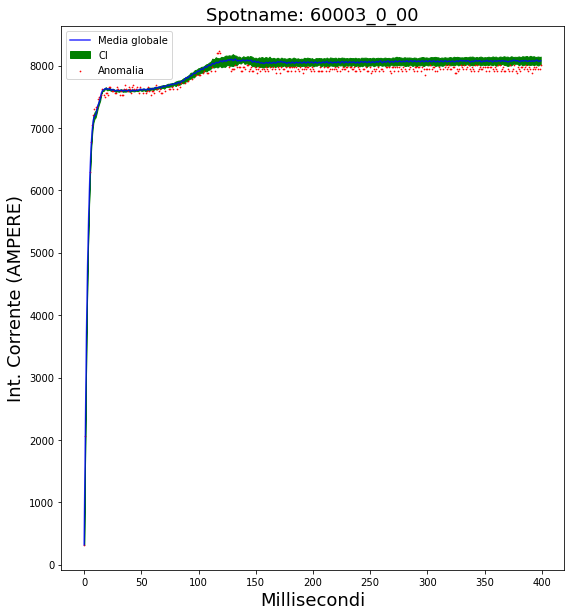

In [8]:
# lista di tuple indice - valore del punto anomalo
list_anomalies = []
for index, row in dict_CI[spotname_test].iterrows():
    if TS_to_test[index] > row['up_bound'] or TS_to_test[index] < row['lw_bound']:
        list_anomalies.append((index, TS_to_test[index]))

df_anomalies = pd.DataFrame(list_anomalies, columns=[
                            'anom_index', 'anom_values'])
plot_CI_TS(spotname_test, dict_CI[spotname_test])
plt.scatter(df_anomalies['anom_index'], df_anomalies['anom_values'],
            s=0.5, color='red', label='Anomalia')
plt.legend()

# CLUSTER SU ANDAMENTO GLOBALE PER OGNI SPOTNAME

### Featuring engineering for clustering

In [9]:
list_rows = []
# creo un dataset contenente per ogni spotname il suo andamento globale
for spotname in list_spotname:
    list_rows.append((spotname, dict_CI[spotname]['mean'].to_list()))

# la colonna mean_CC contiene una lista di valori -> andamento globale
LIST_GLOBAL_TS_SPOT = pd.DataFrame(
    list_rows, columns=['spotname', 'mean_CC']).set_index('spotname')

Dataset contenente per ogni spotname una lista rappresentante il suo andamento medio globale


In [10]:
LIST_GLOBAL_TS_SPOT

,mean_CC
spotname,
60000_0_00,"[309.46, 2013.0, 3619.16, 4766.7, 5623.98, 627..."
60001_0_00,"[319.18, 2054.62, 3678.04, 4818.66, 5653.24, 6..."
60002_0_00,"[309.34000000000003, 2039.96, 3667.92, 4818.48..."
60003_0_00,"[318.62, 2050.6, 3670.46, 4799.5, 5617.96, 623..."
60010_0_00,"[319.56, 2133.88, 3884.62, 5102.46, 5950.34, 6..."
...,...
60180_0_00,"[336.94, 2282.28, 4221.98, 5572.5, 6526.38, 72..."
60181_0_00,"[336.32000000000005, 2227.74, 4128.66, 5489.36..."
60184_0_00,"[327.53999999999996, 2101.6800000000003, 3891...."


In [11]:
exploded_col_lists = LIST_GLOBAL_TS_SPOT['mean_CC'].apply(pd.Series)

# dataframe global esploso x clustering
EXPL_GLOBAL_TS_SPOT = LIST_GLOBAL_TS_SPOT.copy()
EXPL_GLOBAL_TS_SPOT.drop(columns='mean_CC', inplace=True)
EXPL_GLOBAL_TS_SPOT = pd.concat([EXPL_GLOBAL_TS_SPOT, exploded_col_lists],
                                axis=1)

Dataset in cui a ogni valore di ogni saldatura è associata una colonna

In [12]:
EXPL_GLOBAL_TS_SPOT

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
spotname,,,,,,,,,,,,,,,,,,,,,
60000_0_00,309.46,2013.00,3619.16,4766.70,5623.98,6275.10,6757.98,7100.62,7300.96,7385.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60001_0_00,319.18,2054.62,3678.04,4818.66,5653.24,6292.42,6748.14,7061.48,7252.40,7327.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60002_0_00,309.34,2039.96,3667.92,4818.48,5648.86,6266.78,6737.62,7064.84,7244.72,7324.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60003_0_00,318.62,2050.60,3670.46,4799.50,5617.96,6233.96,6676.66,6955.30,7124.52,7197.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60010_0_00,319.56,2133.88,3884.62,5102.46,5950.34,6568.68,7010.46,7289.90,7434.56,7484.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60180_0_00,336.94,2282.28,4221.98,5572.50,6526.38,7209.44,7615.60,7823.90,7900.96,7879.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60181_0_00,336.32,2227.74,4128.66,5489.36,6454.74,7133.26,7540.68,7748.88,7812.10,7760.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60184_0_00,327.54,2101.68,3891.30,5212.22,6171.18,6834.08,7251.32,7521.24,7655.92,7682.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# interpoliamo i NULL linearmente
for i in EXPL_GLOBAL_TS_SPOT.index:
    interpolated = EXPL_GLOBAL_TS_SPOT.loc[i].interpolate(method='pad')
    EXPL_GLOBAL_TS_SPOT.loc[i] = interpolated
    LIST_GLOBAL_TS_SPOT.loc[i]['mean_CC'] = list(interpolated)
EXPL_GLOBAL_TS_SPOT

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
spotname,,,,,,,,,,,,,,,,,,,,,
60000_0_00,309.46,2013.00,3619.16,4766.70,5623.98,6275.10,6757.98,7100.62,7300.96,7385.92,...,7663.80,7663.80,7663.80,7663.80,7663.80,7663.80,7663.80,7663.80,7663.80,7663.80
60001_0_00,319.18,2054.62,3678.04,4818.66,5653.24,6292.42,6748.14,7061.48,7252.40,7327.94,...,8149.60,8149.60,8149.60,8149.60,8149.60,8149.60,8149.60,8149.60,8149.60,8149.60
60002_0_00,309.34,2039.96,3667.92,4818.48,5648.86,6266.78,6737.62,7064.84,7244.72,7324.02,...,7651.16,7651.16,7651.16,7651.16,7651.16,7651.16,7651.16,7651.16,7651.16,7651.16
60003_0_00,318.62,2050.60,3670.46,4799.50,5617.96,6233.96,6676.66,6955.30,7124.52,7197.06,...,8077.14,8077.14,8077.14,8077.14,8077.14,8077.14,8077.14,8077.14,8077.14,8077.14
60010_0_00,319.56,2133.88,3884.62,5102.46,5950.34,6568.68,7010.46,7289.90,7434.56,7484.58,...,7942.00,7942.00,7942.00,7942.00,7942.00,7942.00,7942.00,7942.00,7942.00,7942.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60180_0_00,336.94,2282.28,4221.98,5572.50,6526.38,7209.44,7615.60,7823.90,7900.96,7879.06,...,8221.10,8221.10,8221.10,8221.10,8221.10,8221.10,8221.10,8221.10,8221.10,8221.10
60181_0_00,336.32,2227.74,4128.66,5489.36,6454.74,7133.26,7540.68,7748.88,7812.10,7760.34,...,8545.26,8545.26,8545.26,8545.26,8545.26,8545.26,8545.26,8545.26,8545.26,8545.26
60184_0_00,327.54,2101.68,3891.30,5212.22,6171.18,6834.08,7251.32,7521.24,7655.92,7682.42,...,8598.66,8598.66,8598.66,8598.66,8598.66,8598.66,8598.66,8598.66,8598.66,8598.66


## DBSCAN GLOBALE (Euclidean)

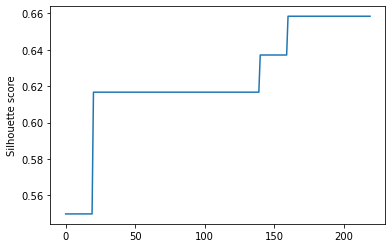

In [14]:
# se non standardizziamo, il modello non è in grado di differenziare i cluster
scaler = StandardScaler()
Glob_std = scaler.fit_transform(EXPL_GLOBAL_TS_SPOT)

# testiamo diversi parametri
list_eps = range(9, 20)
list_min_samples = range(10, 30)
dict_silhouette_score = {}
for eps in list_eps:
    for min_samples in list_min_samples:
        # associamo a ogni TS un cluster
        clustering = DBSCAN(eps=eps, min_samples=eps).fit_predict(Glob_std)
        # salviamo parametri e rispettivo score ottenuto
        dict_silhouette_score[(eps, min_samples)] = metrics.silhouette_score(
            Glob_std, clustering)
# ottengo i parametri che ritornano lo score più alto
eps, min_samples = max(dict_silhouette_score, key=dict_silhouette_score.get)

# alleno il modello con i parametri migliori
clustering = DBSCAN(eps=eps, min_samples=eps).fit_predict(Glob_std)

plt.ylabel("Silhouette score")
plt.plot(dict_silhouette_score.values())

In [15]:
# aggiungiamo +1 per far partire l'indice dei cluster da 0
LIST_GLOBAL_TS_SPOT['DBSCAN_cluster'] = clustering + 1

## HIERARCHICAL GLOBALE (Euclidean + Ward)

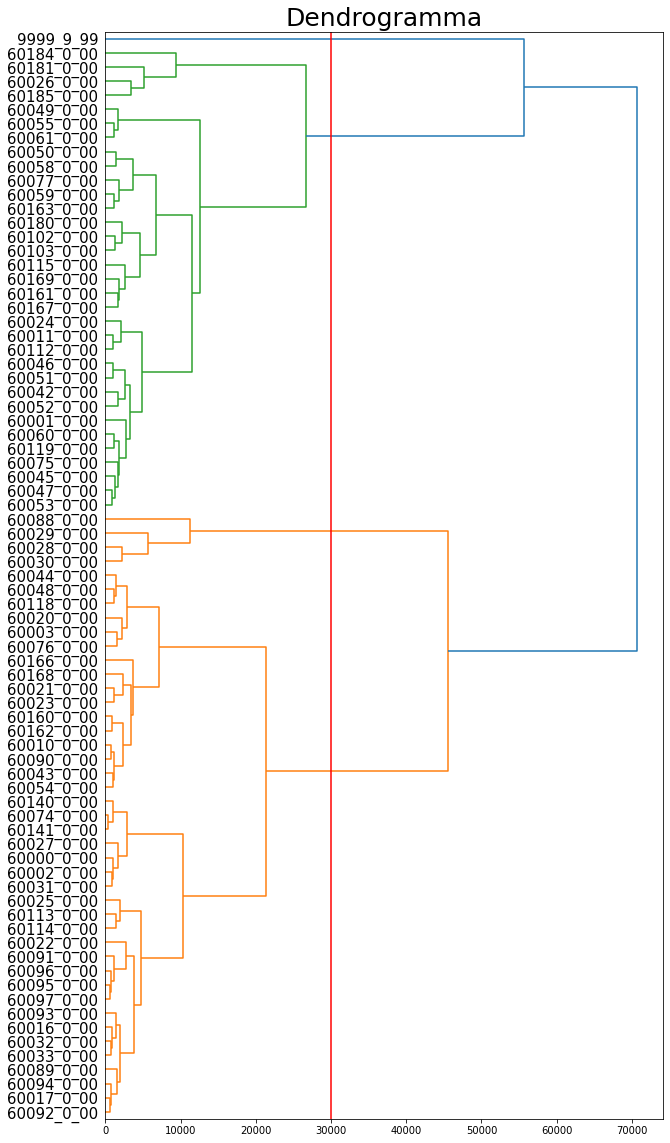

In [16]:
import scipy.cluster.hierarchy as shc

# soglia taglio dendrogramma -> 4 cluster
clu_threshold = 30000

# euclidean + ward
distance_metrics = shc.linkage(EXPL_GLOBAL_TS_SPOT,
                               metric='euclidean', method='ward')
plt.figure(figsize=(10, 20))
plt.title("Dendrogramma", fontsize=25)
dend = shc.dendrogram(distance_metrics, labels=EXPL_GLOBAL_TS_SPOT.index,
                      orientation='right', count_sort='descending', leaf_font_size=15)
plt.axvline(x=clu_threshold, color='red')

In [17]:
# assegno a ogni misurazione globale x spotname un cluster
# togliamo 1 in modo da far partire il numero dei cluster da 0
hier_clu_list = fcluster(
    distance_metrics, clu_threshold, criterion='distance') - 1

# associamo a ogni TS un cluster
LIST_GLOBAL_TS_SPOT['hierachical_cluster'] = hier_clu_list

## DTW GLOBALE

In [18]:
list_max_iter = range(10, 11)
list_n_cluster = range(4, 5)
dict_silhouette_score = {}
for max_iter in list_max_iter:
    for n_cluster in list_n_cluster:
        model = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw",
                                 max_iter=max_iter, random_state=RANDOM_SEED, n_jobs=-1)
        km_means_dtw_clusters = model.fit_predict(EXPL_GLOBAL_TS_SPOT)
        dict_silhouette_score[(max_iter, n_cluster)] = metrics.silhouette_score(
            EXPL_GLOBAL_TS_SPOT, km_means_dtw_clusters, random_state=RANDOM_SEED)

max_iter, n_cluster = max(dict_silhouette_score, key=dict_silhouette_score.get)

model = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw",
                         max_iter=max_iter, random_state=RANDOM_SEED, n_jobs=-1)

# alleno il modello con i parametri migliori
km_means_dtw_clusters = model.fit_predict(EXPL_GLOBAL_TS_SPOT)

In [19]:
# associamo a ogni TS il cluster di appartenenza
LIST_GLOBAL_TS_SPOT['k_means_dtw'] = km_means_dtw_clusters

## PLOT RISULTATI

In [20]:
def plot_cluster(dataframe, cluster_column='k_means_dtw'):
    # ottengo lista indici dei cluster
    list_cluster = dataframe[cluster_column].unique()

    # genero plot pari al numero di cluster
    fig, axs = plt.subplots(1, len(list_cluster),
                            figsize=(15, 7), sharey=True)
    for i in list_cluster:
        axs[i].set(xlabel=f'CLUSTER {i}')

    fig.suptitle(
        f'{cluster_column} --- Cluster degli andamenti medi globali per spotname', fontsize=15)

    # in base all'indice del cluster, plot nello specifico grafico
    for name_spot, row in dataframe.iterrows():
        axs[row[cluster_column]].plot(dataframe.loc[name_spot]
                                      ['mean_CC'], label=name_spot)
        # axs[row['hierchical_cluster']].legend()
    fig.show()

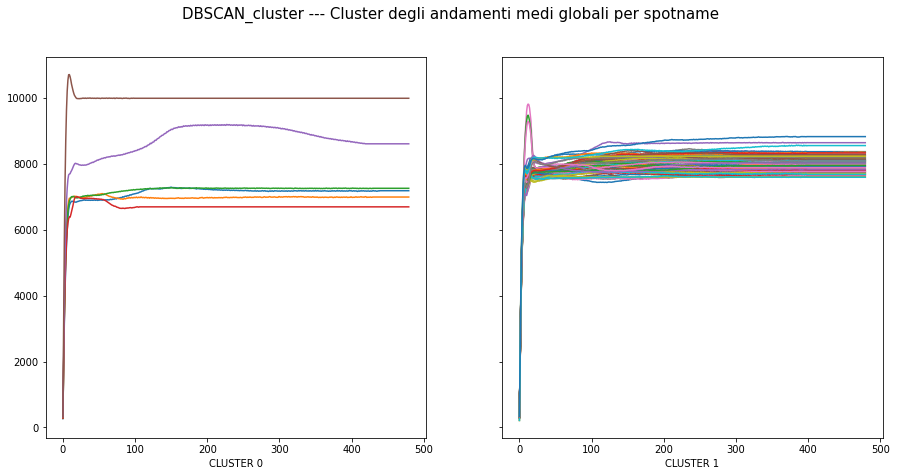

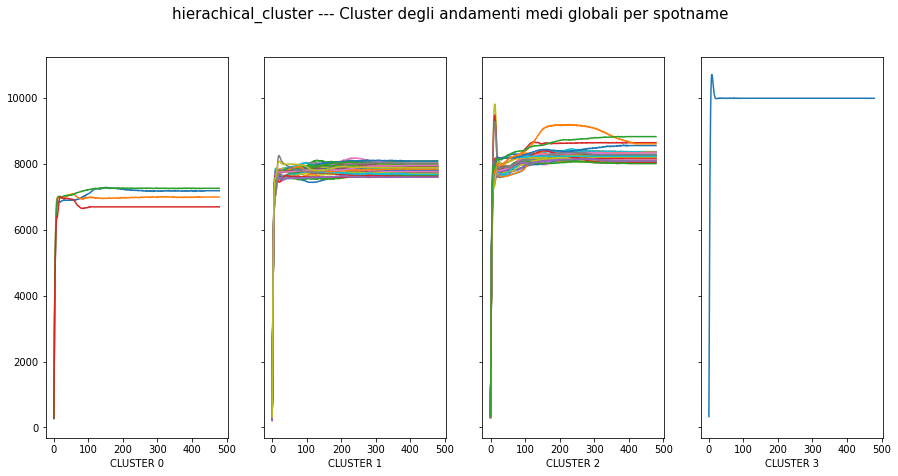

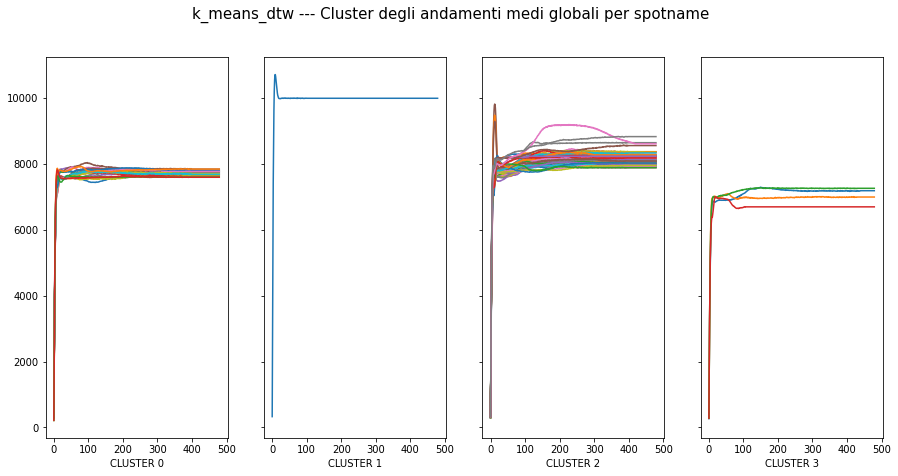

In [21]:
cluster_columns = LIST_GLOBAL_TS_SPOT.columns[1:]
for column_name in cluster_columns:
    plot_cluster(LIST_GLOBAL_TS_SPOT, column_name)

 # TRAINING

In [22]:
# a ogni spotname assegno il rispettivo cluster e nel frattempo ho tutte le sue misurazioni giornaliere
global_CI['k_means_dtw'] = LIST_GLOBAL_TS_SPOT['k_means_dtw']
global_CI

,CurrentCurve,k_means_dtw
spotName,,
60000_0_00,"[[302, 1999, 3574, 4694, 5512, 6148, 6542, 681...",0
60001_0_00,"[[327, 2031, 3604, 4751, 5636, 6193, 6586, 698...",2
60002_0_00,"[[306, 2056, 3713, 4880, 5708, 6353, 6752, 705...",0
60003_0_00,"[[313, 2006, 3573, 4639, 5360, 5893, 6363, 670...",2
60010_0_00,"[[318, 2133, 3885, 5126, 5923, 6559, 7101, 735...",2
...,...,...
60180_0_00,"[[323, 2264, 4172, 5530, 6533, 7180, 7503, 773...",2
60181_0_00,"[[332, 2193, 4087, 5483, 6447, 7045, 7477, 774...",2
60184_0_00,"[[336, 2132, 3965, 5312, 6248, 6921, 7407, 763...",2


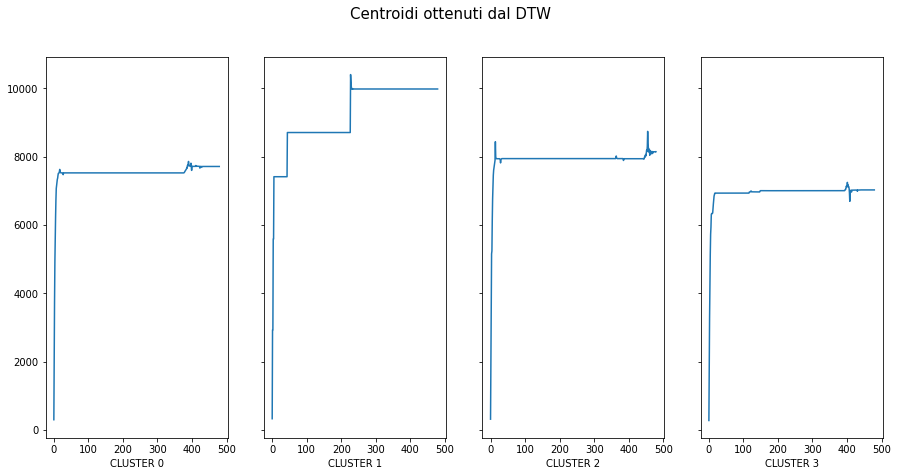

In [23]:
list_centroids = model.cluster_centers_
flatten_centroid = []
# genero plot pari al numero di cluster
fig, axs = plt.subplots(1, len(list_centroids),
                        figsize=(15, 7), sharey=True)

fig.suptitle(
    f'Centroidi ottenuti dal DTW', fontsize=15)

for i in range(0, len(list_centroids)):
    axs[i].set(xlabel=f'CLUSTER {i}')

# estraggo i centroidi per ogni cluster
for i in range(0, len(list_centroids)):
    centroid = list(itertools.chain(*list_centroids[i]))
    # lista di liste con centroidi
    flatten_centroid.append(centroid)
    axs[i].plot(centroid)

# ISOLATION FOREST

In [24]:
from sklearn.ensemble import IsolationForest
# creo una lista il cui INDICE = INDICE CLUSTER e VALORE = MODELLO SPECIFICO PER CLUSTER
# ogni modello è allenato sul centroide della rispettiva classe

contamination = 0.02
list_IF_models = []
for i in range(0, len(flatten_centroid)):
    IF_model = IsolationForest(
        contamination=contamination, random_state=RANDOM_SEED)
    IF_model.fit(np.array(flatten_centroid[i]).reshape(-1, 1))
    list_IF_models.append(IF_model)

In [25]:
# prendiamo una curva giornaliera random di uno spotname in uno specifico cluster
index_cluster = 3
global_test = global_CI[global_CI['k_means_dtw'] ==
                        index_cluster].sample(1, random_state=RANDOM_SEED)

In [26]:
random_CC = global_test['CurrentCurve'][0][0]
daily_TS = np.array(random_CC).reshape(-1, 1)

# modello relativo a quello specifico cluster
TS_test = list_IF_models[index_cluster]

dataset_test = pd.DataFrame(
    {'data': random_CC, 'is_anomaly': TS_test.predict(daily_TS)},
    index=range(0, len(random_CC)))

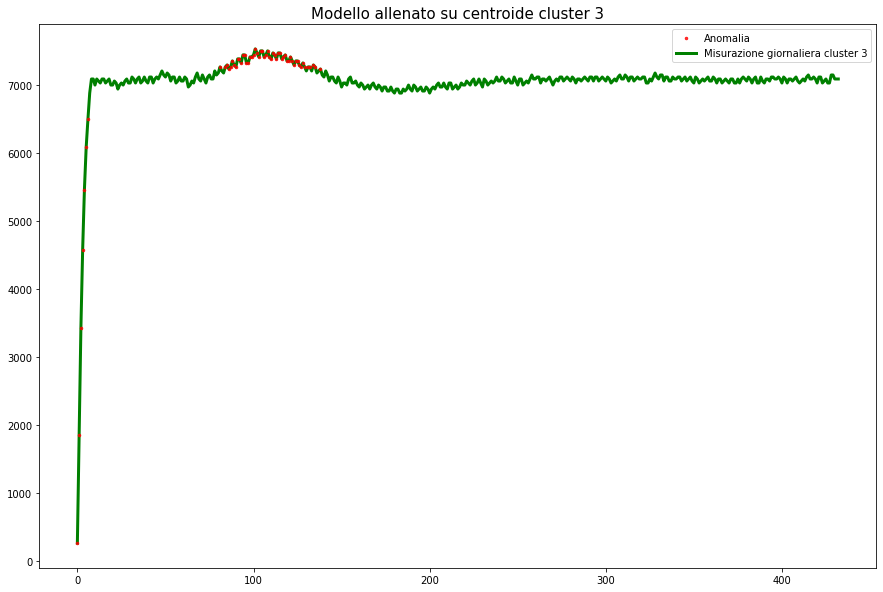

In [27]:
anomaly_points = dataset_test[dataset_test.is_anomaly == -1]

plt.figure(figsize=(15, 10))
plt.title(
    f"Modello allenato su centroide cluster {index_cluster}", fontsize=15)
plt.plot(anomaly_points.index,
         anomaly_points['data'], 'ro', zorder=99, alpha=0.8, markersize=2.5, label='Anomalia')
plt.plot(dataset_test['data'], 'g', linewidth=3,
         zorder=2, label=f'Misurazione giornaliera cluster {index_cluster}')
plt.legend()

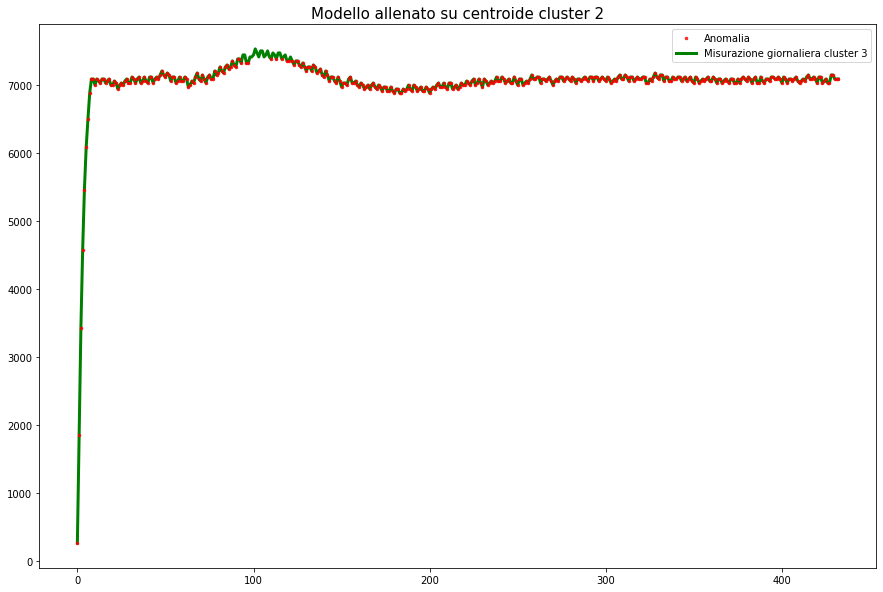

In [28]:
# La curva di sopra appartiene a uno spotname nel cluster 3
# Proviamo ad applicarci anche un modello allenato sui dati del cluster 2

index_modello_cluster = 2
# modello del cluster 2
TS_test = list_IF_models[index_modello_cluster]

dataset_test = pd.DataFrame(
    {'data': random_CC, 'is_anomaly': TS_test.predict(daily_TS)},
    index=range(0, len(random_CC)))

anomaly_points = dataset_test[dataset_test.is_anomaly == -1]

plt.figure(figsize=(15, 10))
plt.title(
    f"Modello allenato su centroide cluster {index_modello_cluster}", fontsize=15)
plt.plot(anomaly_points.index,
         anomaly_points['data'], 'ro', zorder=99, alpha=0.8, markersize=2.5, label='Anomalia')
plt.plot(dataset_test['data'], 'g', linewidth=3,
         zorder=2, label=f'Misurazione giornaliera cluster {index_cluster}')
plt.legend()


# Il modello riconosce che tipicamente le misurazioni degli spotname nel cluster 2 dal tempo
# t = 100 a t = 250 circa assumono un valore molto più alto di 8000, cosa che non accade nella misurazione
# che abbiamo considerato in quanto appartiene al cluster 3! Quindi segnala delle anomalie

# Salvataggio dei modelli per il testing

In [29]:
# dataset con CI andamento globale x spotname
with open('../models/CI_global.pickle', 'wb') as CI_GLOBAL:
    pickle.dump(dict_CI, CI_GLOBAL)

# dizionario con modelli IF x cluster
with open('../models/IF_models_cluster.pickle', 'wb') as IF_models_path:
    pickle.dump(list_IF_models, IF_models_path)

# salvataggio dtw cluster
with open('../models/dtw_cluster.pickle', 'wb') as dtw_models_path:
    pickle.dump(model, dtw_models_path)

# dataset con andamenti giornalieri x spotname e cluster relativo
global_CI.to_pickle('../data/prepared/daily_cluster.pickle')

# Clustering DBSCAN su ogni spotname 

### Preparazione del Dataset

In [30]:
exploded_col_lists = dataset['CurrentCurve'].apply(pd.Series)
expanded_TS_global = pd.concat([dataset, exploded_col_lists],
                               axis=1)
expanded_TS_global.drop(columns='CurrentCurve', inplace=True, errors='Ignore')
# imputiamo i nan sostituendoli con la media delle misurazioni
expanded_TS_global.loc[:, 4:] = expanded_TS_global.loc[:, 4:].apply(
    lambda row: row.fillna(row.mean()), axis=1)

### Creiamo l'algoritmo di clustering 


In [31]:
# lista che conterrà lo scaler e i parametri migliori per uno spotname
dict_scaler_dbscan_daily = {}

In [32]:
def dbscan_for_daily(spotname, ds, eps, min_samples):
    scaler = StandardScaler()
    X = scaler.fit_transform(ds.loc[ds.spotName == spotname, 0:613])
    # train e test parametri
    predictions = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
    # assegno il risultato dell'algoritmo al database
    ds.loc[ds.spotName == spotname, 'dbscan_daily'] = predictions
    # salvo scaler e parametri
    dict_scaler_dbscan_daily[spotname] = scaler

In [33]:
# settiamo con un valore costante la colonna che conterrà la previsione del dbscan
expanded_TS_global['dbscan_daily'] = 2
# svolgiamo le previsioni per ogni CC giornaliera di ogni spotname
for spotname in tqdm(expanded_TS_global.spotName.unique(), total = len(expanded_TS_global.spotName.unique())):
    dbscan_for_daily(spotname, expanded_TS_global, 30, 20)

100%|███████████████████████████████████████████████████████████████████████| 77/77 [00:14<00:00,  5.40it/s]


In [34]:
expanded_TS_global['dbscan_daily'].unique()

array([ 0, -1], dtype=int64)

## Visualizziamo i risultati ottenuti su un sottoinsieme degli spotname

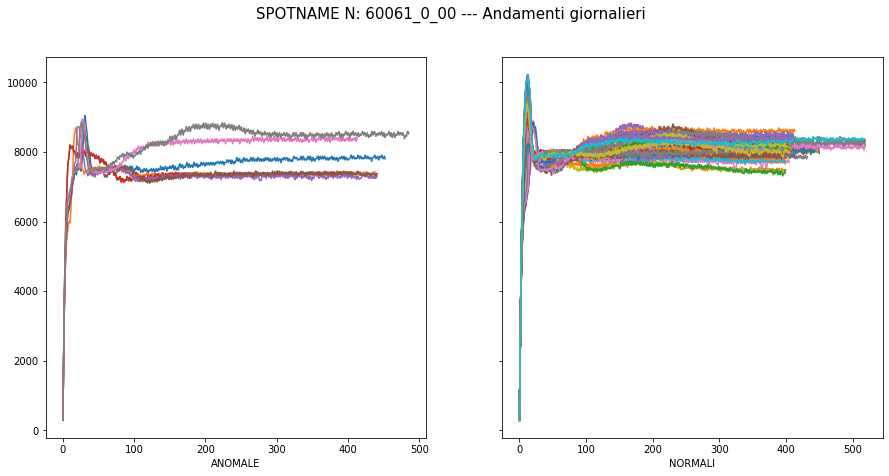

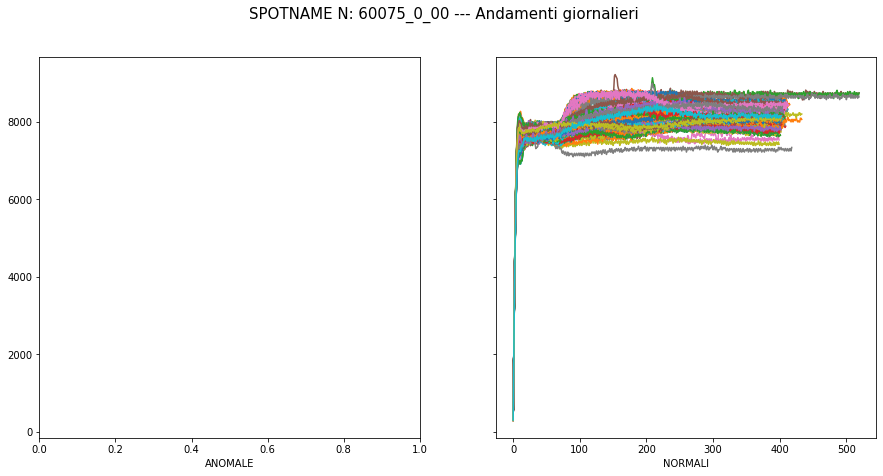

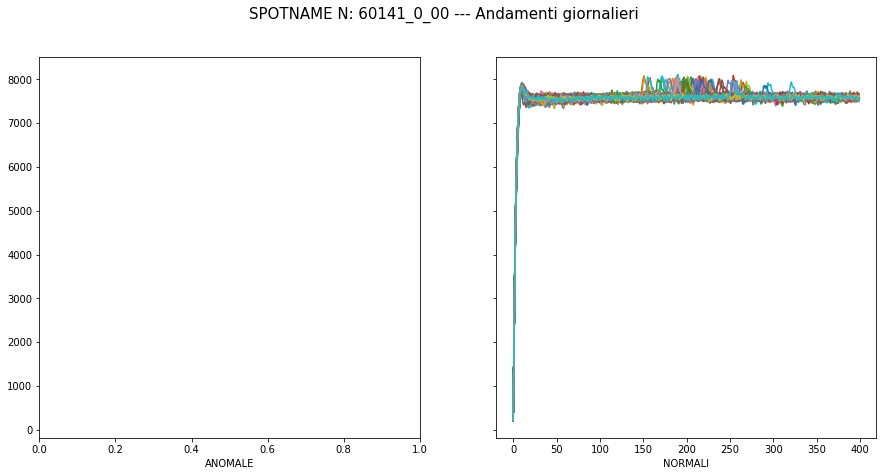

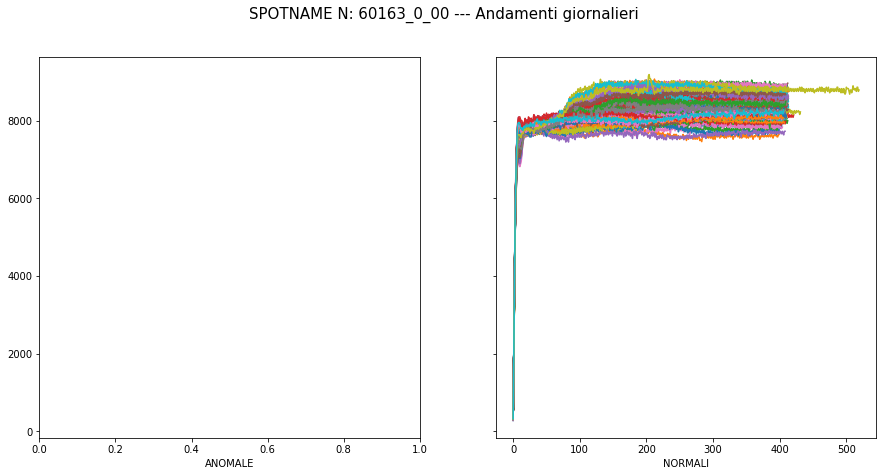

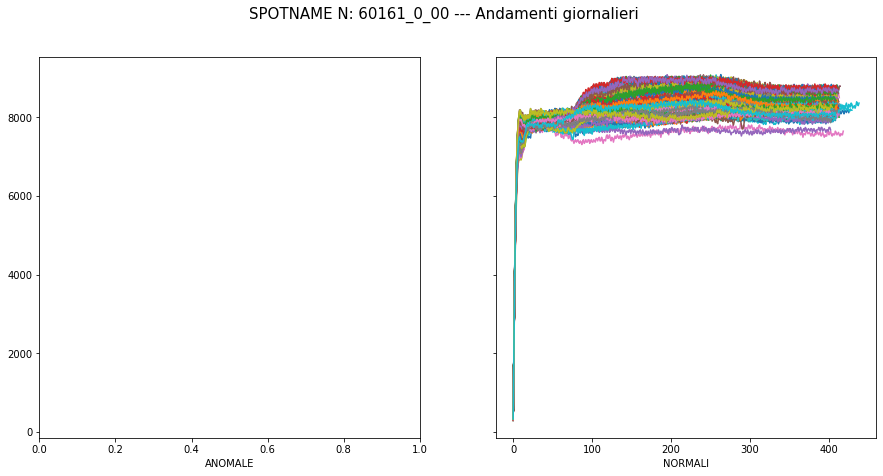

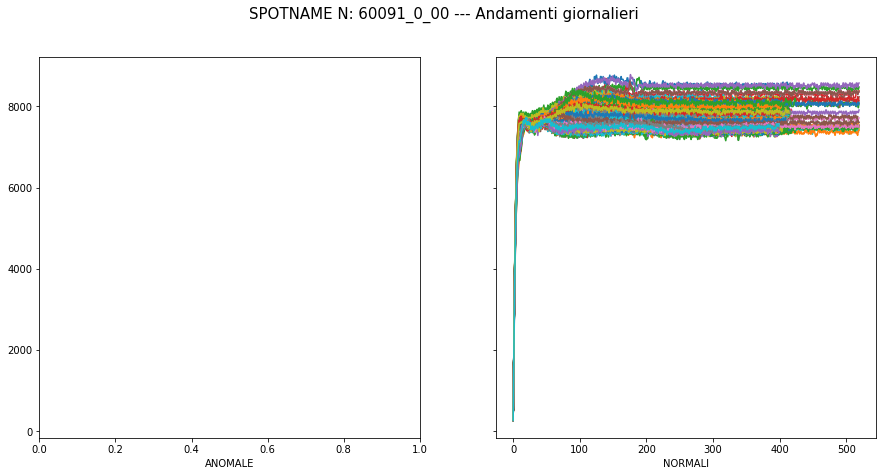

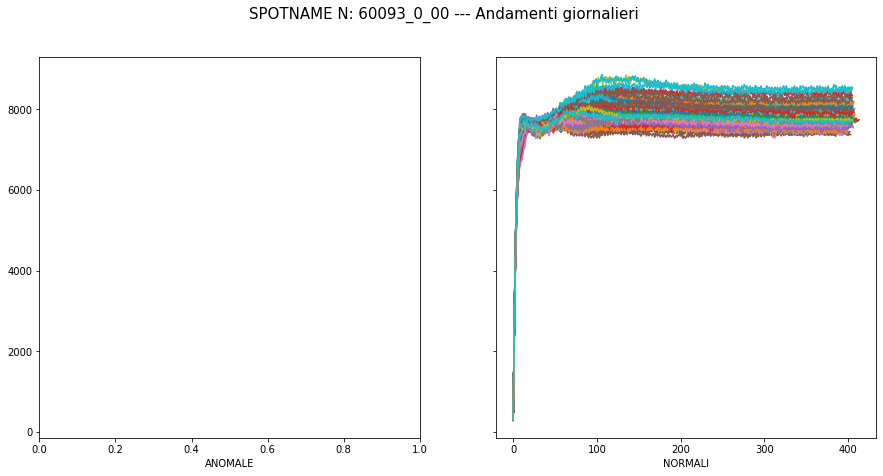

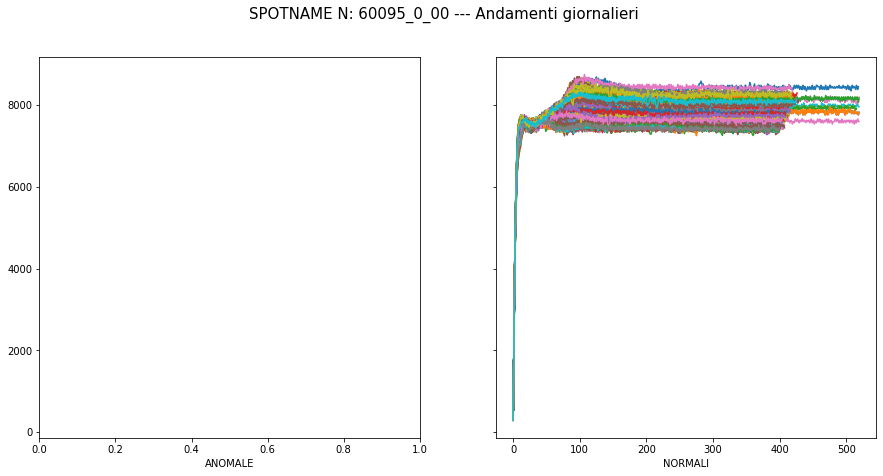

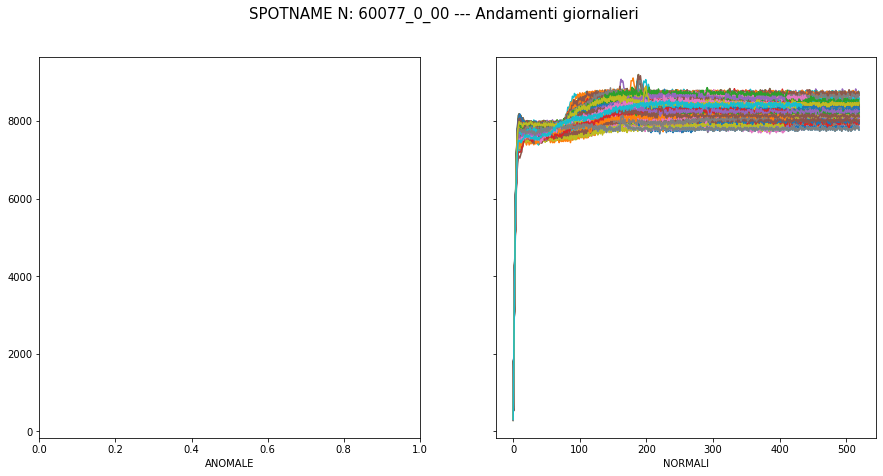

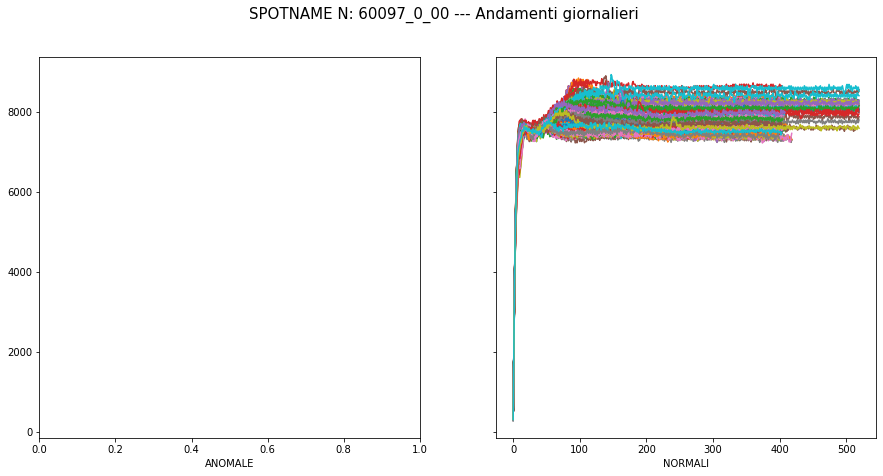

In [35]:
# numero di CC giornaliere da visualizzare per spotname
# all'aumentare del numero aumenta di molto il tempo di esecuzione
total_daily_per_spot = 200
# totale spotname da visualizzare
tot_spotname = 10
for i, spotname in enumerate(expanded_TS_global.spotName.unique()[0:tot_spotname]):
    data = dataset.loc[(expanded_TS_global.spotName == spotname)]
    anomalies = data[expanded_TS_global.dbscan_daily == -1]
    not_anomalies = data[expanded_TS_global.dbscan_daily == 0]
    # genero plot pari al numero di cluster
    fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    axs[0].set(xlabel=f'ANOMALE')
    axs[1].set(xlabel=f'NORMALI')
    fig.suptitle(
        f'SPOTNAME N: {spotname} --- Andamenti giornalieri', fontsize=15)
    # in base all'indice del cluster, plot nello specifico grafico
    for anom in anomalies['CurrentCurve'].values[0:total_daily_per_spot]:
        axs[0].plot(anom)
    for not_anom in not_anomalies['CurrentCurve'].values[0:total_daily_per_spot]:
        axs[1].plot(not_anom)
    plt.show()

In [36]:
# dizionario spotname-scaler per testare le CC GIORNALIERE con il DBSCAN
with open('../models/dbscan_daily_scaler.pickle', 'wb') as dbscan_daily:
    pickle.dump(dict_scaler_dbscan_daily, dbscan_daily)

# colonna contenente le previsioni del dbscan per ogni CC nel training
with open('../models/list_dbscan_daily_predictions.pickle', 'wb') as dbscan_daily_pred:
    pickle.dump(expanded_TS_global['dbscan_daily'], dbscan_daily_pred)